# Signal processing

In [1]:
import numpy as np
import pandas as pd
from obspy import read
import matplotlib.pyplot as plt
import os
from scipy.signal import butter, lfilter
import features as ft
from scipy.signal import freqz
import datetime
from scipy.stats import norm

In [2]:
# Set the working directory to the location of the data files
os.chdir("C:\\Users\\javie\\OneDrive - INSTITUTO TECNOLOGICO AUTONOMO DE MEXICO\\MaestriaEnCienciaDeDatos\\EstanciaDeInvestigacion\\Popocatepelt\\PopocatepetlVolcano\\data")
# os.chdir("D:/Popocatepetl/data/clean_data/2023")

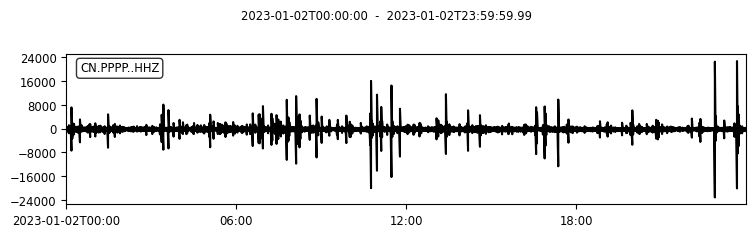

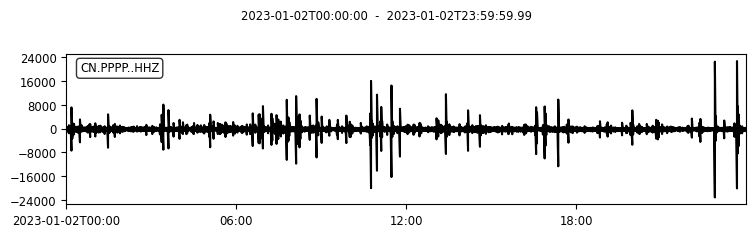

In [3]:
# We select a day with high volcanic activity
st = read("CN_PPPP_HHZ_2023_01_02.seed")
st.plot()

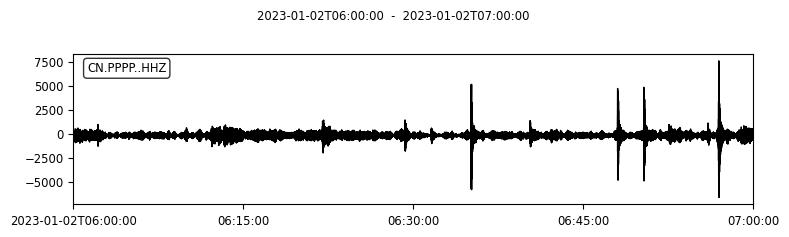

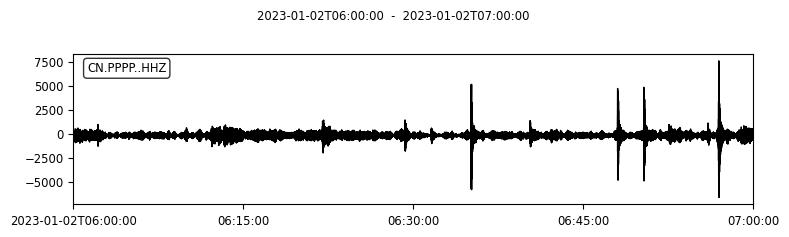

In [4]:
# Extracting a 1-hour segment
t = st[0].stats.starttime
hour = st.slice(t+3600*6, t+3600*7)
hour.plot()

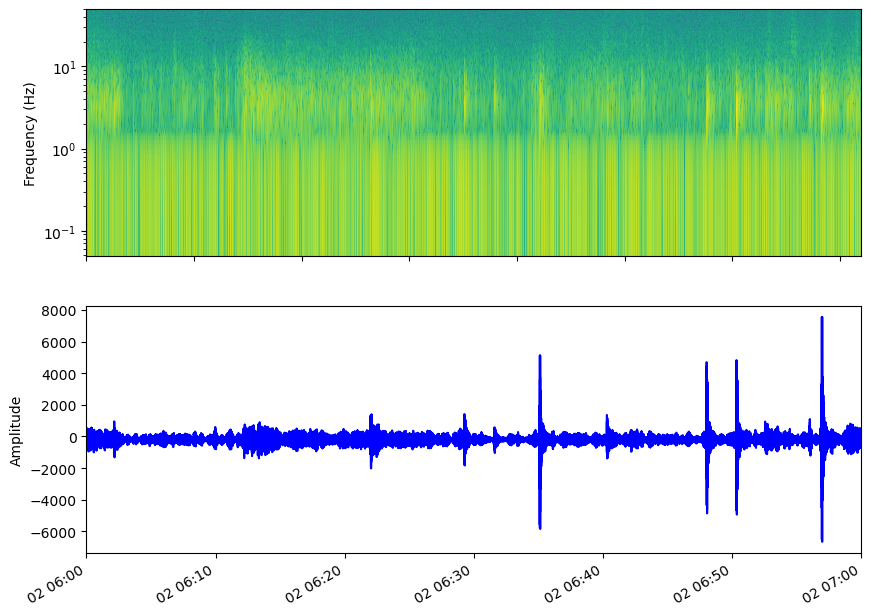

In [6]:
# Waveform and spectrogram graph
ft.plot_signal(hour[0])

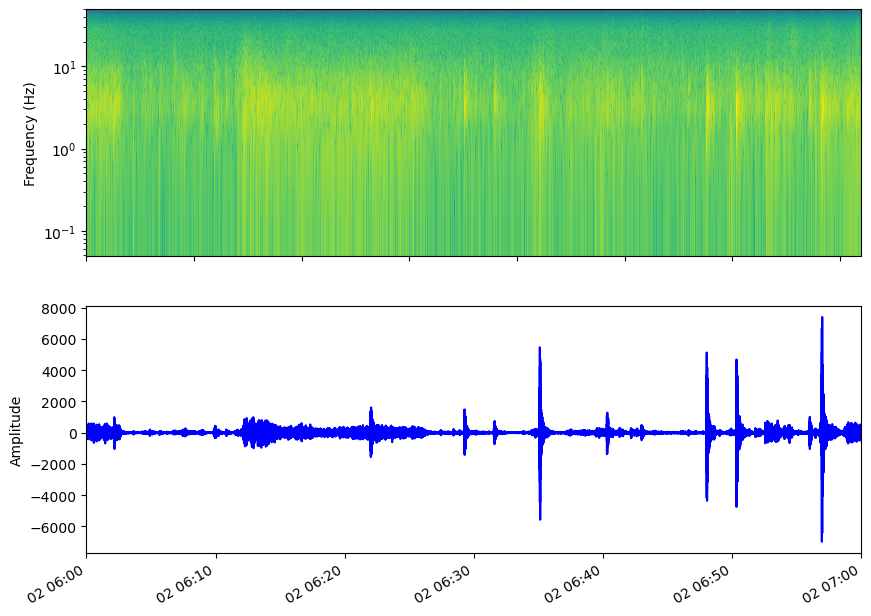

In [ ]:
[filtered_signal, s_low, s_high] = ft.load_and_preprocess_seismic_data("CN_PPPP_HHZ_2023_01_02.seed")
filtered_signal = filtered_signal.slice(t+3600*6, t+3600*7)
# Waveform and spectrogram graph
ft.plot_signal(filtered_signal[0])

In [14]:
def entropy(S):
    """
    Calculate the Shannon entropy of a signal assuming a normal distribution.

    Parameters:
    - S: array-like
        Input signal data (e.g., seismic amplitudes).

    Returns:
    - shannon_entropy: float
        Shannon entropy value of the input signal.
    """
    # Fit a normal distribution to the signal data
    (mu, sigma) = norm.fit(S)
    # Sort the signal data to compute the PDF
    Sor = np.sort(S)
    # Calculate the probability density function (PDF) of the normal distribution
    y = norm.pdf(Sor, mu, sigma)
    # Avoid log(0) by adding a small value to the PDF
    y_adjusted = y + np.finfo(float).eps
    # Calculate the Shannon entropy
    shannon_entropy = -np.sum(y_adjusted * np.log2(y_adjusted))
    return shannon_entropy

def calculate_entropy_windowed(trace, window_size_seconds=600, overlap=0.5):
    """
    Calculate entropy using sliding windows with overlap
    
    Parameters:
    - trace: ObsPy Trace object
    - window_size_seconds: window size in seconds (default: 600 = 10 minutes)
    - overlap: overlap fraction between windows (default: 0.5 = 50%)
    
    Returns:
    - DataFrame with timestamps and entropy values
    """
    # Get sampling rate and calculate window size in samples
    sampling_rate = trace.stats.sampling_rate
    window_samples = int(window_size_seconds * sampling_rate)
    
    # Calculate step size (distance between window starts)
    step_samples = int(window_samples * (1 - overlap))
    
    # Get the signal data
    signal = trace.data
    
    # Initialize lists to store results
    timestamps = []
    entropy_values = []
    
    # Slide the window through the signal
    for i in range(0, len(signal) - window_samples + 1, step_samples):
        # Extract window
        window = signal[i:i + window_samples]
        
        # Calculate timestamp for the center of the window
        window_center_sample = i + window_samples // 2
        timestamp = trace.stats.starttime + window_center_sample / sampling_rate
        
        # Calculate energy: mean of squared amplitudes
        entropy_value = entropy(window)
        
        # Store results
        timestamps.append(timestamp.datetime)
        entropy_values.append(entropy_value)
    
    # Create DataFrame with results
    results_df = pd.DataFrame({
        'timestamp': timestamps,
        'entropy': entropy_values
    })
    
    return results_df

Calculated energy for 11 windows
            timestamp      entropy
0 2023-01-02 06:05:00  1688.659598
1 2023-01-02 06:10:00  1208.911158
2 2023-01-02 06:15:00  1023.726351
3 2023-01-02 06:20:00  1097.614479
4 2023-01-02 06:25:00  1174.876644


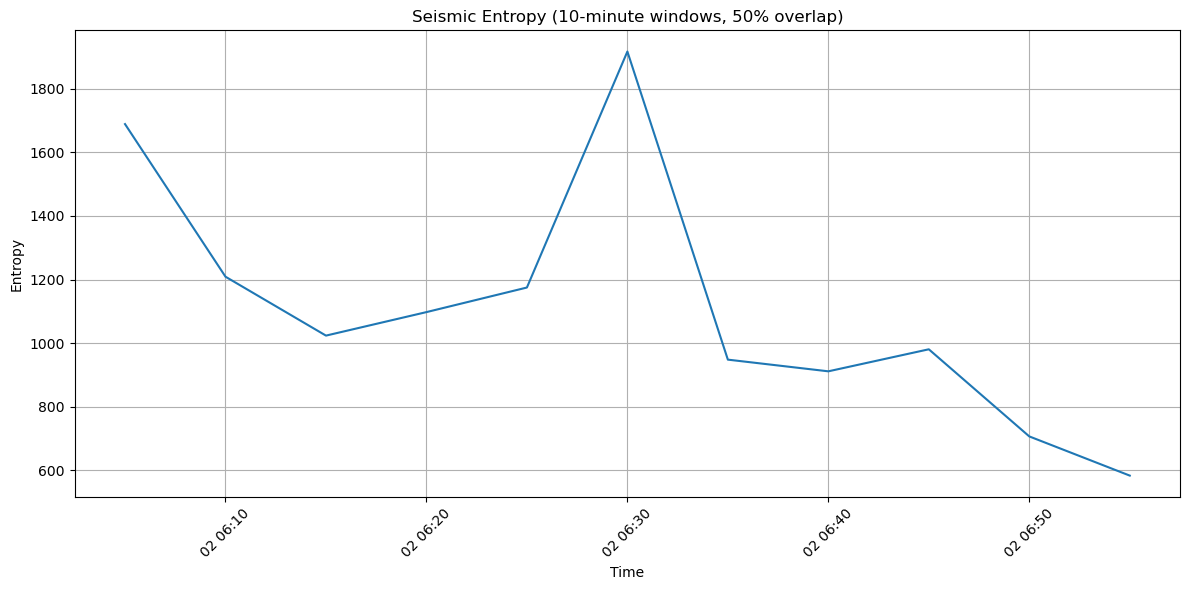

In [ ]:
# Example usage:
# Assuming you have a trace object called 'trace'
entropy_df = calculate_entropy_windowed(filtered_signal[0], window_size_seconds=600, overlap=0.5)

# Display the results
print(f"Calculated energy for {len(entropy_df)} windows")
print(entropy_df.head())

plt.figure(figsize=(12, 6))
plt.plot(entropy_df['timestamp'], entropy_df['entropy'])
plt.xlabel('Time')
plt.ylabel('Entropy')
plt.title('Seismic Entropy (10-minute windows, 50% overlap)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def freq_index(s_low, s_high, samples):
    """
    Calculate the frequency index as the log-ratio of high-frequency to low-frequency energy.

    Parameters:
    - s_low: array-like
        Signal data for the low-frequency band.
    - s_high: array-like
        Signal data for the high-frequency band.
    - samples: int
        Number of samples in each window.

    Returns:
    - freq_index: float
        Logarithmic ratio of high-frequency to low-frequency energy.
    """
    ener_low = np.sum(s_low**2) / samples
    ener_high = np.sum(s_high**2) / samples

    # Avoid division by zero by adding a small value to the denominator
    freq_index = np.log10(ener_high / (ener_low + np.finfo(float).eps))
    return freq_index

def calculate_freq_index_windowed(trace, s_high, window_size_seconds=600, overlap=0.5):
    """
    Calculate frecuency index using sliding windows with overlap
    
    Parameters:
    - trace: ObsPy Trace object
    - window_size_seconds: window size in seconds (default: 600 = 10 minutes)
    - overlap: overlap fraction between windows (default: 0.5 = 50%)
    
    Returns:
    - DataFrame with timestamps and entropy values
    """
    # Get sampling rate and calculate window size in samples
    sampling_rate = trace.stats.sampling_rate
    window_samples = int(window_size_seconds * sampling_rate)
    
    # Calculate step size (distance between window starts)
    step_samples = int(window_samples * (1 - overlap))
    
    # Get the signal data
    signal_low = trace.data
    signal_high = s_high.data
    
    # Initialize lists to store results
    timestamps = []
    freq_index_values = []
    
    # Slide the window through the signal
    for i in range(0, len(signal_low) - window_samples + 1, step_samples):
        # Extract window
        window_low = signal_low[i:i + window_samples]
        window_high = signal_high[i:i + window_samples]
        
        # Calculate timestamp for the center of the window
        window_center_sample = i + window_samples // 2
        timestamp = trace.stats.starttime + window_center_sample / sampling_rate
        
        # Calculate energy: mean of squared amplitudes
        freq_index_value = freq_index(window_low, window_high, window_samples)
        
        # Store results
        timestamps.append(timestamp.datetime)
        freq_index_values.append(freq_index_value)
    
    # Create DataFrame with results
    results_df = pd.DataFrame({
        'timestamp': timestamps,
        'freq_index': freq_index_values
    })
    
    return results_df

Calculated frecuency index for 11 windows
            timestamp  freq_index
0 2023-01-02 06:05:00   -1.235938
1 2023-01-02 06:10:00   -0.026238
2 2023-01-02 06:15:00   -0.071926
3 2023-01-02 06:20:00   -0.752196
4 2023-01-02 06:25:00   -0.961545


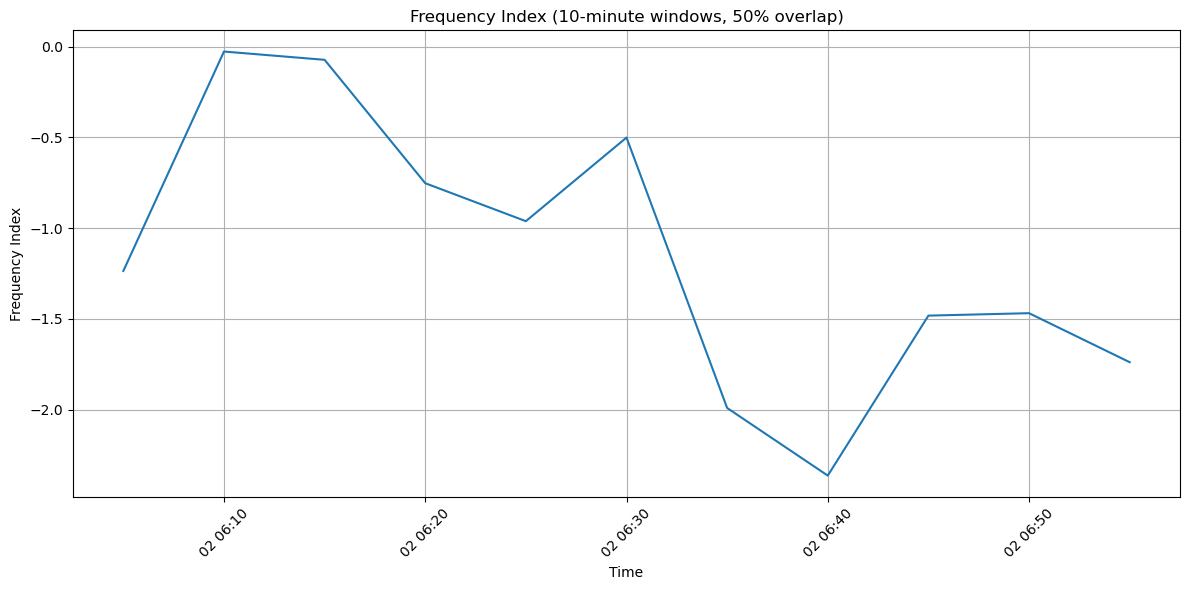

In [16]:
# Example usage:
# Assuming you have a trace object called 'trace'
freq_index_df = calculate_freq_index_windowed(trace = s_low[0], s_high = s_high[0], window_size_seconds=600, overlap=0.5)

# Display the results
print(f"Calculated frecuency index for {len(freq_index_df)} windows")
print(freq_index_df.head())

plt.figure(figsize=(12, 6))
plt.plot(freq_index_df['timestamp'], freq_index_df['freq_index'])
plt.xlabel('Time')
plt.ylabel('Frequency Index')
plt.title('Frequency Index (10-minute windows, 50% overlap)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()